### These jupyter can reproduced the results of figure2 in our papers.
### you can use these functions we defined to evaluate the performance of each method with 10-X cross-validation.
### If you want to use each method to analyse youe own data, please see the Tutorial.ipynb

# 

### Please note: We used raw count as input for predictions in this ipynb !!!

### In our manuscripts, we tested four schemes of input expression matrices: 
### (1) raw expression matrix of spatial data and raw expression matrix of scRNA-seq data (R-R); 
### (2) normalized expression matrix of spatial data and raw expression matrix of scRNA-seq data (N-R); 
### (3) raw expression matrix of spatial data and normalized expression matrix of scRNA-seq data (R-N); 
### (4) normalized expression matrix of spatial data and normalized expression matrix of scRNA-seq data (N-N).

### For N-N and N-R input, we calculate the accuracy by comapring the prediction result with normalized matrix of spatial data.
### For R-R and R-N input, we calculate the accuracy by comapring the prediction result with raw expression matrix of spatial data.

In [1]:
import numpy as np
import pandas as pd
import sys
import pickle
import os
import time as tm
from functools import partial
import scipy.stats as st
from scipy.stats import wasserstein_distance
import scipy.stats
import copy
from sklearn.model_selection import KFold
import pandas as pd
import multiprocessing
import matplotlib as mpl 
import matplotlib.pyplot as plt
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')

from scipy.spatial import distance_matrix
from sklearn.metrics import matthews_corrcoef
from scipy import stats
import seaborn as sns

from scipy.spatial.distance import cdist
import h5py
from scipy.stats import spearmanr

import time
import sys
import tangram as tg
from os.path import join
from IPython.display import display


# Calculated Metrics

In [2]:
test_cells = 10
iterations = 10
fraction = 10


In [3]:
# paths

DataDir = 'xenium data/Figure2/downsampling_' + str(test_cells) + '/iterations_' + str(iterations) + '/split_' + str(fraction) + '/impute/'
print(DataDir)

outdir = DataDir + 'metrics/'

print(outdir)
if not os.path.exists(outdir):
    os.mkdir(outdir) 

    
# test_cells = 1/ int(test_cells)
print(test_cells)


xenium data/Figure2/downsampling_10/iterations_10/split_10/impute/
xenium data/Figure2/downsampling_10/iterations_10/split_10/impute/metrics/
10


In [4]:
spatial_data_file = '/spatial_data.csv'

In [5]:
# spatial_data_test = pd.read_csv(spatial_data_file, index_col = 0)
# spatial_data_test['Angpt1']

In [6]:
# impute_test = pd.read_csv(DataDir + '/SpaGE_impute.csv', index_col = 0)
# impute_test['Angpt1']

In [35]:
def cal_ssim(im1,im2,M):
    assert len(im1.shape) == 2 and len(im2.shape) == 2
    assert im1.shape == im2.shape
    mu1 = im1.mean()
    mu2 = im2.mean()
    sigma1 = np.sqrt(((im1 - mu1) ** 2).mean())
    sigma2 = np.sqrt(((im2 - mu2) ** 2).mean())
    sigma12 = ((im1 - mu1) * (im2 - mu2)).mean()
    k1, k2, L = 0.01, 0.03, M
    C1 = (k1*L) ** 2
    C2 = (k2*L) ** 2
    C3 = C2/2
    l12 = (2*mu1*mu2 + C1)/(mu1 ** 2 + mu2 ** 2 + C1)
    c12 = (2*sigma1*sigma2 + C2)/(sigma1 ** 2 + sigma2 ** 2 + C2)
    s12 = (sigma12 + C3)/(sigma1*sigma2 + C3)
    ssim = l12 * c12 * s12
    
    return ssim

def scale_max(df):
    result = pd.DataFrame()
    for label, content in df.items():

        content = content/content.max()
        result = pd.concat([result, content],axis=1)
    return result

def scale_z_score(df):
    result = pd.DataFrame()
    for label, content in df.items():
        content = st.zscore(content)
        content = pd.DataFrame(content,columns=[label])
        result = pd.concat([result, content],axis=1)
    return result


def scale_plus(df):
    result = pd.DataFrame()
    for label, content in df.items():
        content = content/content.sum()
        result = pd.concat([result,content],axis=1)
    return result

def logNorm(df):
    df = np.log1p(df)
    df = st.zscore(df)
    return df
    
class CalculateMeteics:
    def __init__(self, raw_count_file, impute_count_file, prefix, metric):
        self.impute_count_file = impute_count_file
        self.raw_count = pd.read_csv(raw_count_file, header = 0, index_col=0)
        self.raw_count.columns = [x.upper() for x in self.raw_count.columns]
        self.raw_count = self.raw_count.T
        self.raw_count = self.raw_count.loc[~self.raw_count.index.duplicated(keep='first')].T
        self.raw_count = self.raw_count.fillna(1e-20)
        
        
        if isinstance(impute_count_file,pd.DataFrame):
            self.impute_count = impute_count_file
            
        else: 
            self.impute_count = pd.read_csv(impute_count_file, header = 0, index_col = 0)
            
        self.impute_count.columns = [x.upper() for x in self.impute_count.columns]
        self.impute_count = self.impute_count.T
        self.impute_count = self.impute_count.loc[~self.impute_count.index.duplicated(keep='first')].T
        self.impute_count = self.impute_count.fillna(1e-20)
        self.prefix = prefix
        self.metric = metric
        

        
    def SSIM(self, raw, impute, scale = 'scale_max'):
        if scale == 'scale_max': # so that expression value of each gene was between 0 and 1

            # raw = 'scale: ', scale_max(raw)
            raw = scale_max(raw)
            impute = scale_max(impute)
            
        else:
            print ('Please note you do not scale data by scale max')
            
            
        if raw.shape[0] == impute.shape[0]:
            result = pd.DataFrame()
            for label in raw.columns:
                if label not in impute.columns:
                    ssim = 0
                else:
                
                    raw_col =  raw.loc[:,label]
                    impute_col = impute.loc[:,label]
                    impute_col = impute_col.fillna(1e-20)
                    raw_col = raw_col.fillna(1e-20)
                    M = [raw_col.max(),impute_col.max()][raw_col.max()>impute_col.max()]
                    raw_col_2 = np.array(raw_col)
                    raw_col_2 = raw_col_2.reshape(raw_col_2.shape[0],1)
                    impute_col_2 = np.array(impute_col)
                    impute_col_2 = impute_col_2.reshape(impute_col_2.shape[0],1)
                    ssim = cal_ssim(raw_col_2,impute_col_2,M)
                
                ssim_df = pd.DataFrame(ssim, index=["SSIM"],columns=[label])
                
                result = pd.concat([result, ssim_df],axis=1)
                
            result = result.loc[:, (result != 0).any(axis=0)]
        else:
            print("columns error")
            
        
        return result
            
    def PCC(self, raw, impute, scale = None):
        if raw.shape[0] == impute.shape[0]:
            result = pd.DataFrame()
            
            print('raw columns: ', len(raw.columns)) 
            print('impute columns: ', len(impute.columns)) 
            
            for label in raw.columns:
                if label not in impute.columns:
                    pearsonr = 0
                else:
                    raw_col =  raw.loc[:,label]
                    impute_col = impute.loc[:,label]
                    impute_col = impute_col.fillna(1e-20)
                    raw_col = raw_col.fillna(1e-20)
                    pearsonr, _ = st.pearsonr(raw_col,impute_col)
                pearson_df = pd.DataFrame(pearsonr, index=["PCC"],columns=[label])
                result = pd.concat([result, pearson_df],axis=1)
                
            result = result.loc[:, (result != 0).any(axis=0)]
        else:
            print("columns error")
        return result
    
    def JS(self, raw, impute, scale = 'scale_plus'):
        
        raw = raw.reset_index(drop=True)
        
        if scale == 'scale_plus':
            raw = scale_plus(raw)
            impute = scale_plus(impute)
        else:
            print ('Please note you do not scale data by plus')    
        if raw.shape[0] == impute.shape[0]:
            result = pd.DataFrame()
            for label in raw.columns:
                if label not in impute.columns:
                    print(label)
                    JS = 1
                else:
                    raw_col =  raw.loc[:,label]
                    impute_col = impute.loc[:,label]
                    raw_col = raw_col.fillna(1e-20)
                    impute_col = impute_col.fillna(1e-20)
                    M = (raw_col + impute_col)/2
                    
                    if len(M) != len(impute_col):
                        print(raw_col + impute_col)
                    JS = 0.5*st.entropy(raw_col,M)+0.5*st.entropy(impute_col,M)
                    
                JS_df = pd.DataFrame(JS, index=["JS"],columns=[label])
                result = pd.concat([result, JS_df],axis=1)
                
            result = result.loc[:, (result != 1).any(axis=0)]
        else:
            print("columns error")
        return result
    
    def RMSE(self, raw, impute, scale = 'zscore'):
        if scale == 'zscore':
            raw = scale_z_score(raw)
            impute = scale_z_score(impute)
        else:
            print ('Please note you do not scale data by zscore')
        if raw.shape[0] == impute.shape[0]:
            result = pd.DataFrame()
            for label in raw.columns:
                if label not in impute.columns:
                    RMSE = 1.5   
                else:
                    raw_col =  raw.loc[:,label]
                    impute_col = impute.loc[:,label]
                    impute_col = impute_col.fillna(1e-20)
                    raw_col = raw_col.fillna(1e-20)
                    RMSE = np.sqrt(((raw_col - impute_col) ** 2).mean())

                RMSE_df = pd.DataFrame(RMSE, index=["RMSE"],columns=[label])
                result = pd.concat([result, RMSE_df],axis=1)
                
            result = result.loc[:, (result != 1.5).any(axis=0)]
        else:
            print("columns error")
        return result       
        
    def compute_all(self):
        
        global outdir
        
        raw = self.raw_count
        raw = raw.reset_index(drop=True)
        impute = self.impute_count
        impute = impute.reset_index(drop=True)
        
        
        prefix = self.prefix
        SSIM = self.SSIM(raw,impute)
        Pearson = self.PCC(raw, impute)
        JS = self.JS(raw, impute)
        RMSE = self.RMSE(raw, impute)
        
        result_all = pd.concat([Pearson, SSIM, RMSE, JS],axis=0)
        result_all.T.to_csv(outdir + prefix + '_Metrics' + '.txt', sep='\t', header = 1, index = 1)
        self.accuracy = result_all
        return result_all


In [72]:
impute_count_dir = DataDir 
os.listdir(impute_count_dir)

['metrics', 'SpaGE', 'SpaOTsc', 'gimVI', '280 genes', 'novoSpaRc', 'Tangram']

In [73]:
import seaborn as sns
import os

# DirFiles = os.listdir(DataDir)


def CalDataMetric(Data):
    # print ('We are calculating the : ' + Data + '\n')
    
    global test_cells, spatial_data_file
    
    

    metric = ['PCC','SSIM','RMSE','JS']
    impute_count_dir = DataDir 
    
    print('impute count directory: ', impute_count_dir)
    
    impute_count = os.listdir(impute_count_dir)
    impute_count = [x for x in impute_count if x != 'metrics']
    impute_count = [x for x in impute_count if x != '280 genes']
    
    print('impute count dirs: ', impute_count)
    
    
    if len(impute_count)!=0:
        for method in impute_count:
            
            print(method)
            
            method_dir = impute_count_dir + method + '/'
            
            # for all iterations
            impute_count_dfs = pd.DataFrame()
            
            for i in range(iterations):
            
                impute_count_file = method_dir + method + '_impute' + '_iteration' + str(i) + '.csv'
                print('file: ', impute_count_file)
                
                impute_count_df = pd.read_csv(impute_count_file, header = 0, index_col = 0)
                
                impute_count_dfs = pd.concat([impute_count_dfs,impute_count_df], axis=1, ignore_index=False)
                
            impute_count_dfs.to_csv(method_dir + method + '_impute_concat' + '.csv')
            print(method_dir + method + '_impute_concat' + '.csv')
                
            impute_count_file = impute_count_dfs
            
            
            prefix = method
            
            print('prefix: ',prefix)
            
            raw_count_file = method_dir + spatial_data_file
            
            print('raw file: ', raw_count_file)
            
                      
            
            # if not os.path.isfile(outdir + prefix + '_Metrics' + '.txt'):
                
            CM = CalculateMeteics(raw_count_file = raw_count_file, impute_count_file = impute_count_file, prefix = prefix, metric = metric)
            CM.compute_all()


In [74]:
DataSets = ['Figure2']
with multiprocessing.Pool(10) as pool:
    pool.map(CalDataMetric, DataSets)
    

impute count directory:  xenium data/Figure2/downsampling_10/iterations_10/split_10/impute/
impute count dirs:  ['SpaGE', 'SpaOTsc', 'gimVI', 'novoSpaRc', 'Tangram']
SpaGE
file:  xenium data/Figure2/downsampling_10/iterations_10/split_10/impute/SpaGE/SpaGE_impute_iteration0.csv
file:  xenium data/Figure2/downsampling_10/iterations_10/split_10/impute/SpaGE/SpaGE_impute_iteration1.csv
file:  xenium data/Figure2/downsampling_10/iterations_10/split_10/impute/SpaGE/SpaGE_impute_iteration2.csv
file:  xenium data/Figure2/downsampling_10/iterations_10/split_10/impute/SpaGE/SpaGE_impute_iteration3.csv
file:  xenium data/Figure2/downsampling_10/iterations_10/split_10/impute/SpaGE/SpaGE_impute_iteration4.csv
file:  xenium data/Figure2/downsampling_10/iterations_10/split_10/impute/SpaGE/SpaGE_impute_iteration5.csv
file:  xenium data/Figure2/downsampling_10/iterations_10/split_10/impute/SpaGE/SpaGE_impute_iteration6.csv
file:  xenium data/Figure2/downsampling_10/iterations_10/split_10/impute/SpaGE/

# DataSet Boxplot for 4 mertrics

In [67]:
def plot_boxplot(PATH,Data,metric,Tools,outdir):
    global impute_file_name, test_cells, iterations, fraction
    
    # palette = ["#F5A8C7", '#F9EC31', "#D6DE23", "#988DC3", "#BBA8D1", "#A2CBCF", "#7BD1F1", "#79c06e"]
    palette = ["#F5A8C7", '#F9EC31', "#D6DE23", "#988DC3", "#7BD1F1"]

    font = {'family':'DejaVu Sans','weight':'normal','size':15}
    fig = plt.figure(figsize=(20,4), dpi= 80)
    result = pd.DataFrame()
    metrics = metric
    
    fig.suptitle('downsample: ' + str(test_cells) + ', iterations: ' + str(iterations) + ', training split: ' + str(fraction),
          fontsize=12)
    
    for tool in Tools:
        print(tool)
        result_metrics = pd.read_csv(PATH  + '/' + tool + '_Metrics' + '.txt', sep = '\t', header = 0, index_col = 0)
        result_metrics['tool'] = tool
        result = pd.concat([result, result_metrics],axis=0) 
        
    print(result)
        
    n = 141
    for method in metrics:
        ax1 = plt.subplot(n)
        ax1 = sns.barplot(x = method, y = "tool", data = result, ci = 95, palette = palette)
        # ax1.set_xlabel(method)
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)

        n = n + 1 
        
#         plt.xticks(size=12) 
#         plt.yticks(size=12) 

#         plt.xlabel('genes', fontsize=12)
        plt.ylabel('', fontsize=12)
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42

        


    OutPdf = outdir
    if not os.path.exists(OutPdf):
        os.mkdir(OutPdf)
    plt.savefig(OutPdf + Data + '_metrics' + '.png')
    plt.savefig(OutPdf + Data + '_metrics' + '.pdf')
    plt.show()


Tangram
gimVI
SpaGE
SpaOTsc
novoSpaRc
                    PCC      SSIM      RMSE        JS       tool
2010300C02RIK  0.722462  0.429890  0.745035  0.117246    Tangram
ACSBG1         0.733485  0.689956  0.730089  0.266385    Tangram
ACTA2         -0.008024  0.156628  1.419876  0.621869    Tangram
ACVRL1         0.048291  0.115516  1.379644  0.555500    Tangram
ADAMTS2        0.343988  0.289940  1.145437  0.477702    Tangram
...                 ...       ...       ...       ...        ...
VWC2L          0.173180  0.042411  1.285939  0.571288  novoSpaRc
WFS1           0.377233  0.053670  1.116035  0.398829  novoSpaRc
ZFP366         0.399233  0.268064  1.096145  0.536089  novoSpaRc
ZFP536         0.381735  0.307197  1.111993  0.378885  novoSpaRc
ZFPM2          0.379776  0.179165  1.113754  0.398773  novoSpaRc

[1400 rows x 5 columns]


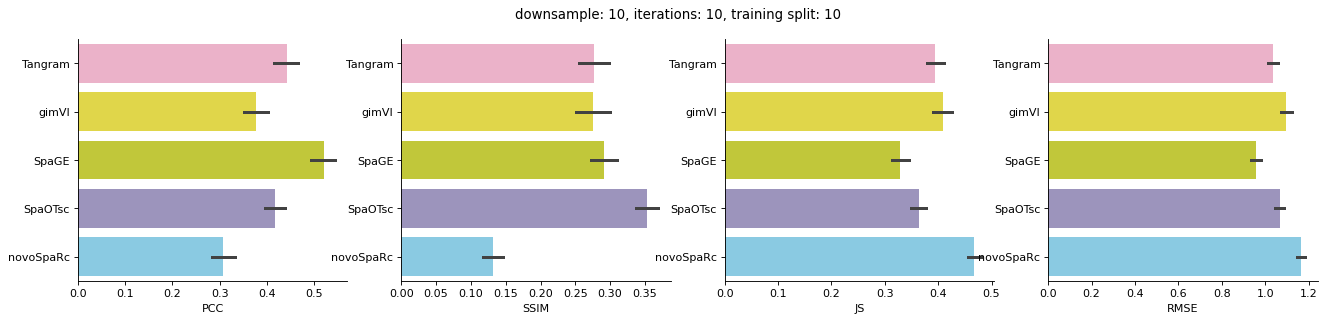

In [50]:
import seaborn as sns
PATH = outdir
metric = ['PCC', 'SSIM', 'JS', 'RMSE']
Data = 'Figure2'
Tools = ['Tangram', 'gimVI', 'SpaGE','SpaOTsc', 'novoSpaRc']
# Tools = ['SpaGE', 'SpaOTsc', 'novoSpaRc']

outdir = PATH

if not os.path.exists(outdir):
    os.system('mkdir ' + outdir)
plot_boxplot(PATH, Data, metric,Tools,outdir)




### genes plot

In [51]:
def plot_boxplot(PATH,Data,metric,Tools,outdir):
    global impute_file_name, test_cells, iterations, fraction
    
    # palette = ["#F5A8C7", '#F9EC31', "#D6DE23", "#988DC3", "#BBA8D1", "#A2CBCF", "#7BD1F1", "#79c06e"]
    palette = ["#F5A8C7", '#F9EC31', "#D6DE23", "#988DC3", "#7BD1F1"]

    font = {'family':'DejaVu Sans','weight':'normal','size':15}
    fig = plt.figure(figsize=(18,16), dpi= 80)
    metrics = metric
    
    fig.suptitle('downsample: ' + str(test_cells) + ', iterations: ' + str(iterations) + ', training split: ' + str(fraction),
          fontsize=12)
 

    # PCC for each method
    
    result = pd.DataFrame()

    PCC_tools = []
    
    
    for tool in Tools:
        tool_path = PATH  + '/' + tool + '_Metrics' + '.txt'
        PCC_tool = 'PCC_' + tool
        
        PCC_tools.append(PCC_tool)
        
        result_metrics = pd.read_csv(tool_path, sep = '\t', header = 0, index_col = 0)
        
        result_metrics = result_metrics.rename(columns = {'PCC':PCC_tool})
        
        result = pd.concat([result, result_metrics[[PCC_tool]]],axis=1)      

    # print(result)
    
    
    
    # find average PCC over methods
    
    result['mean PCC'] = result.mean(axis=1)
    
    result.reset_index(inplace=True)
    result = result.sort_values(by=['mean PCC'], ascending=False, ignore_index=True)
    result = result.rename(columns = {'index':'genes'})
    # print(result)
    
    genes_by_PCC = result
    genes_by_PCC = genes_by_PCC.sort_values(by=['mean PCC'], ascending=False, ignore_index=True)
    genes_by_PCC = genes_by_PCC.reset_index(inplace=False)
    genes_by_PCC = genes_by_PCC.rename(columns = {'index':'order'})
    print(genes_by_PCC)
    
    # repeat dataframe x len(Tools)
    genes_by_PCC = pd.concat([genes_by_PCC]*len(Tools), ignore_index=True)
    genes_by_PCC = genes_by_PCC.sort_values(by=['genes'], ascending=True, ignore_index=True)

    # print(genes_by_PCC)

    
    
        
#     # find average PCC over methods
#     genes_unique = result['genes'].unique()
#     genes_mean = []

#     for gene in genes_unique:
#         gene_mean = result['PCC'][result['genes']==gene].mean()
        
#         for tool in Tools:  
#             genes_mean.append(gene_mean)
        
#     result['mean PCC'] = genes_mean
    
#     result = result.sort_values(by=['mean PCC', 'genes'], ascending=False, ignore_index=True)
#     print(result)



# add order and tool to result

    result = pd.DataFrame()

    for tool in Tools:
            tool_path = PATH  + '/' + tool + '_Metrics' + '.txt'
            print(tool)
            result_metrics = pd.read_csv(tool_path, sep = '\t', header = 0, index_col = 0)
            result_metrics['tool'] = tool
            result = pd.concat([result, result_metrics],axis=0) 
        

    

    result.reset_index(inplace=True)
    result = result.rename(columns = {'index':'genes'})
    result = result.sort_values(by=['genes'], ascending=True, ignore_index=True)
        
    result = pd.concat([result, genes_by_PCC[['order','mean PCC']]],axis=1)
    result = pd.concat([result, genes_by_PCC[PCC_tools]],axis=1)
    result = result.sort_values(by=['order'], ascending=True, ignore_index=True)

    print(result)

        
        
    n = 221
    for method in metrics:
        ax1 = plt.subplot(n)
        ax1 = sns.barplot(x = 'PCC', y = 'genes', data = result[:100], hue = 'tool', ci = 95, palette = palette)
        ax1.set_xlabel(method)
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        n = n + 1 
        
        plt.xticks(size=12) 
        plt.yticks(size=12) 

        plt.xlabel('genes', fontsize=12)
        plt.ylabel('PCC', fontsize=12)

    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42

    OutPdf = outdir
    if not os.path.exists(OutPdf):
        os.mkdir(OutPdf)
    plt.savefig(OutPdf + Data + '_genes_PCC' + '.pdf')
    plt.show()
    
    return result, PCC_tools


     order    genes  PCC_Tangram  PCC_gimVI  PCC_SpaGE  PCC_SpaOTsc  \
0        0    PVALB     0.863247   0.790103   0.830335     0.740347   
1        1     GAD1     0.874238   0.850603   0.820092     0.695857   
2        2   GARNL3     0.795234   0.811111   0.816370     0.770566   
3        3     GAD2     0.829518   0.792075   0.814572     0.709415   
4        4  SLC17A7     0.832572   0.883619   0.711861     0.662490   
..     ...      ...          ...        ...        ...          ...   
275    275      PLN     0.059729   0.023645   0.077488     0.026955   
276    276      DCN     0.068305  -0.003145   0.031899     0.118354   
277    277     PRPH     0.079434   0.003274   0.026483     0.010598   
278    278     CCL3     0.036751   0.007785   0.051921     0.027722   
279    279   SLC6A3     0.040789   0.023270  -0.003343    -0.000784   

     PCC_novoSpaRc  mean PCC  
0         0.816353  0.808077  
1         0.682154  0.784589  
2         0.716967  0.782049  
3         0.636906  0.7

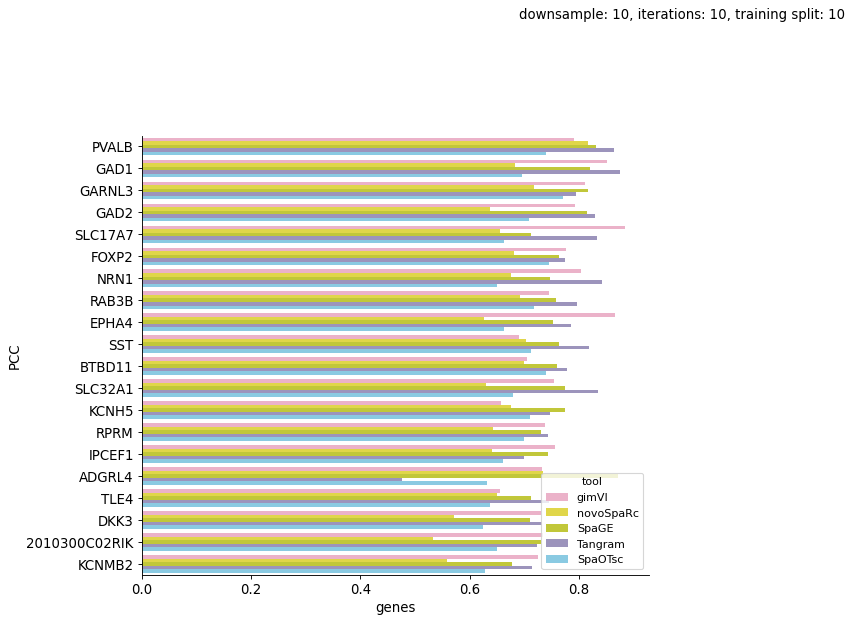

['PCC_Tangram', 'PCC_gimVI', 'PCC_SpaGE', 'PCC_SpaOTsc', 'PCC_novoSpaRc']


In [52]:
import seaborn as sns
PATH = outdir
metric = ['PCC'] #, 'SSIM', 'JS', 'RMSE']
Data = 'Figure2'
Tools = ['Tangram', 'gimVI', 'SpaGE', 'SpaOTsc','novoSpaRc']#,'SpaOTsc']
# Tools = ['SpaGE', 'SpaOTsc', 'novoSpaRc']

outdir = PATH

if not os.path.exists(outdir):
    os.system('mkdir ' + outdir)
    
result, PCC_tools = plot_boxplot(PATH, Data, metric,Tools,outdir)

print(PCC_tools)




In [53]:
# print(PCC_tools)
# PCC_plot = PCC_tools.copy()
# PCC_plot.append('genes')
# print(PCC_plot)
# print(PCC_tools)


In [54]:
# result_plot = result[PCC_plot].drop_duplicates(ignore_index=True)
# print(result_plot)

In [55]:
result = result.sort_values(by=['order'], ascending=True, ignore_index=True)
# result[result['order']==0]
result

,genes,PCC,SSIM,RMSE,JS,tool,order,mean PCC,PCC_Tangram,PCC_gimVI,PCC_SpaGE,PCC_SpaOTsc,PCC_novoSpaRc
0,PVALB,0.790103,0.800604,0.647914,0.255480,gimVI,0,0.808077,0.863247,0.790103,0.830335,0.740347,0.816353
1,PVALB,0.816353,0.725900,0.606048,0.355281,novoSpaRc,0,0.808077,0.863247,0.790103,0.830335,0.740347,0.816353
2,PVALB,0.830335,0.761522,0.582520,0.167128,SpaGE,0,0.808077,0.863247,0.790103,0.830335,0.740347,0.816353
3,PVALB,0.863247,0.790406,0.522978,0.255245,Tangram,0,0.808077,0.863247,0.790103,0.830335,0.740347,0.816353
4,PVALB,0.740347,0.767630,0.720628,0.201045,SpaOTsc,0,0.808077,0.863247,0.790103,0.830335,0.740347,0.816353
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,SLC6A3,0.019004,0.033114,1.400711,0.677813,novoSpaRc,279,0.015787,0.040789,0.023270,-0.003343,-0.000784,0.019004
1396,SLC6A3,0.040789,0.008580,1.385071,0.671592,Tangram,279,0.015787,0.040789,0.023270,-0.003343,-0.000784,0.019004
1397,SLC6A3,-0.003343,0.105179,1.416576,0.688251,SpaGE,279,0.015787,0.040789,0.023270,-0.003343,-0.000784,0.019004
1398,SLC6A3,0.023270,0.010034,1.397663,0.675876,gimVI,279,0.015787,0.040789,0.023270,-0.003343,-0.000784,0.019004


['PCC_Tangram', 'PCC_gimVI', 'PCC_SpaGE', 'PCC_SpaOTsc', 'PCC_novoSpaRc']
xenium data/Figure2/downsampling_10/iterations_10/split_10/impute/metrics/Figure2_genes_PCC.pdf


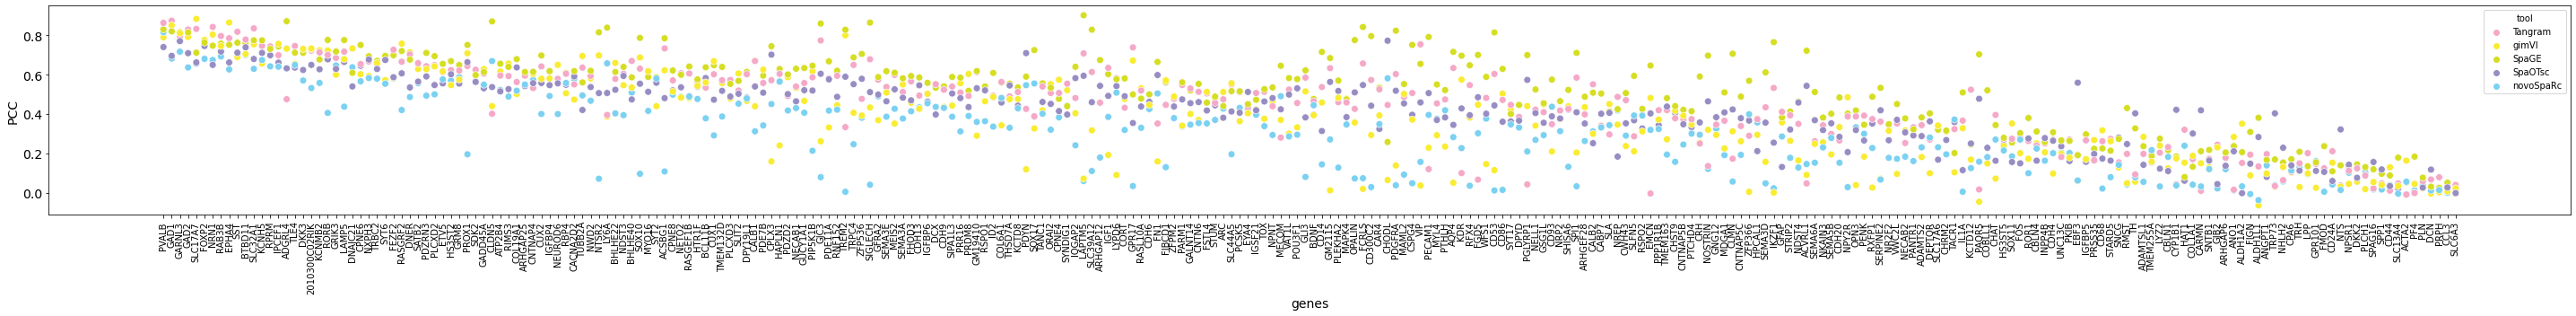

In [64]:
import seaborn as sns
print(PCC_tools)

palette = ["#F5A8C7", '#F9EC31', "#D6DE23", "#988DC3"]#, "#BBA8D1"]#, "#A2CBCF", "#7BD1F1", "#79c06e"]
palette = ["#F5A8C7", '#F9EC31', "#D6DE23", "#988DC3", "#7BD1F1"]

tool_order = ['Tangram', 'gimVI', 'SpaGE', 'SpaOTsc','novoSpaRc']

font = {'family':'DejaVu Sans','weight':'normal','size':12}
# markers = {"Lunch": "s", "Dinner": "X"}
# markers = {'SpaGE':'V', 'SpaOTsc':'p', 'Tangram': 'D','novoSpaRc':'o','gimVI':'s'}
markers = ['D','s', 'V','p','o']

fig = plt.figure(figsize=(40,5))#, dpi= 80)

# sns.scatterplot(x = 'genes', y = 'PCC', data = result[::20], hue = 'tool', ci = 95, palette = palette, markers=markers)
sns.scatterplot(x = 'genes', y = 'PCC', data = result[:], hue = 'tool', hue_order = tool_order, ci = 95, palette = palette,  markers=markers, s=60)

plt.xticks(rotation = 90, size=10) 
plt.yticks(size=14) 

save_name = outdir + Data + '_genes_PCC' + '.png'
save_name = outdir + Data + '_genes_PCC' + '.pdf'
print(save_name)
plt.xlabel('genes', fontsize=14)
plt.ylabel('PCC', fontsize=14)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


# plt.legend(bbox_to_anchor=(1.001, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig(save_name)

plt.show()



# Calculated Accuracy score for every datasets of each methods

In [47]:
###This script is used for rank get the rank score for each method

def get_score(Result):
    Result = Result.fillna(0)
    tools_num = Result.shape[0]
    Tools_score=[]
    methods = list(Result.index)
    score_col = []
    list_up = list(range(1,Result.shape[1]+1))
    list_down  = list(range(Result.shape[1],0,-1))
    
    for method in methods:
        if method == 'PCC' or method == 'SSIM':
            Tools_score.append(pd.Series(list_down, index=Result.loc[method,:].sort_values(ascending=False).index))
            
        if method == 'JS' or method == 'RMSE':
            Tools_score.append(pd.Series(list_up, index=Result.loc[method,:].sort_values(ascending=False).index))
        score_col.append(method)
        
    score=pd.concat([m for m in Tools_score],axis=1)
    score.columns = score_col
    score = score/Result.shape[1]
    return score

def make_score(path, dataset_all, Tools, path_output):
    Tools_data=[x for x in range(len(Tools))]
    for dataset in dataset_all:
        for i in range(len(Tools)):
            File = path  + '/' + Tools[i] + '_Metrics' + '.txt'
            print(File)
            if os.path.isfile(File): 
                Tools_data[i] = pd.read_table(path + '/' + Tools[i] + '_Metrics' + '.txt',sep='\t',index_col=0, header=0)
                Tools_data[i] = Tools_data[i].mean()
                Tools_data[i]['Tool'] = Tools[i]
            else:
                Tools_data[i] = pd.DataFrame([-2, -2, 10, 10], columns = ['Genes'], index = ['PCC', 'SSIM', 'RMSE', 'JS']).T
                Tools_data[i] = Tools_data[i].mean()
                Tools_data[i]['Tool'] = Tools[i]
        Result=pd.concat([m for m in Tools_data], axis=1)
        Result.columns = Result.loc[["Tool"],:].values.flatten()
        Result.drop('Tool', axis = 0, inplace = True)    
            
        score = get_score(Result)
        
        print(score) 
        
        score.to_csv(path_output + '/acc_score' + '.txt', header=1, index=1)




In [48]:
path = outdir 
path_output = outdir

if not os.path.exists(path_output):
    os.mkdir(path_output)
Tools = ['Tangram', 'gimVI', 'SpaGE', 'SpaOTsc', 'novoSpaRc']
# Tools = ['SpaGE', 'SpaOTsc', 'novoSpaRc']

DirFiles = os.listdir(path)

# dataset_all = [x for x in DirFiles if x[:4] == 'Data']
dataset_all = ['Figure2']


print (len(dataset_all))

make_score(path, dataset_all, Tools, path_output)


1
xenium data/Figure2/downsampling_10/iterations_10/split_10/impute/metrics//Tangram_Metrics.txt
xenium data/Figure2/downsampling_10/iterations_10/split_10/impute/metrics//gimVI_Metrics.txt
xenium data/Figure2/downsampling_10/iterations_10/split_10/impute/metrics//SpaGE_Metrics.txt
xenium data/Figure2/downsampling_10/iterations_10/split_10/impute/metrics//SpaOTsc_Metrics.txt
xenium data/Figure2/downsampling_10/iterations_10/split_10/impute/metrics//novoSpaRc_Metrics.txt
           PCC  SSIM  RMSE   JS
SpaGE      1.0   0.8   1.0  1.0
Tangram    0.8   0.6   0.8  0.6
SpaOTsc    0.6   1.0   0.6  0.8
gimVI      0.4   0.4   0.4  0.4
novoSpaRc  0.2   0.2   0.2  0.2


# Accuracy for one datasets

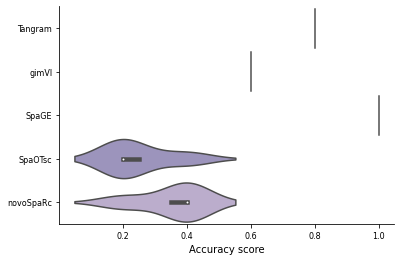

In [21]:
def make_plot_one_dataset(path, Data,order,palette):
    dataset = pd.read_csv(path + '/'  + '/acc_score'  + '.txt', header = 0, index_col = 0)

    dataset_mer = pd.concat([dataset.iloc[:,0],dataset.iloc[:,1],dataset.iloc[:,2],dataset.iloc[:,3]], axis = 0)
    dataset_mer  = pd.DataFrame(dataset_mer,index =dataset_mer.index.values,columns=[Data])
    axes =sns.violinplot(x = Data,y = dataset_mer.index.values, data = dataset_mer ,order = order,palette = palette, width = 0.9)
    axes.set_xlabel('Accuracy score', fontsize = 10)
    axes.set_ylabel('', fontsize = 10)
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    plt.savefig(path + '/' + 'Figure2_violinplot'  + '.pdf')
    plt.show()

    
dataset='Figure2'
order = ['Tangram', 'gimVI', 'SpaGE', 'SpaOTsc', 'novoSpaRc']
# order = ['SpaGE', 'SpaOTsc', 'novoSpaRc']

palette = ["#F5A8C7", '#F9EC31', "#D6DE23", "#988DC3", "#BBA8D1", "#A2CBCF", "#7BD1F1", "#79c06e"]
make_plot_one_dataset(path, dataset,order,palette)



# Accuracy for image, seq based

45
28
17


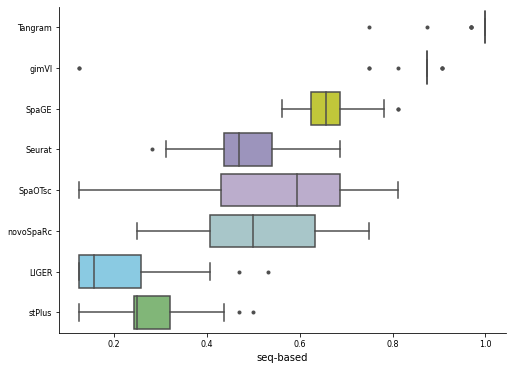

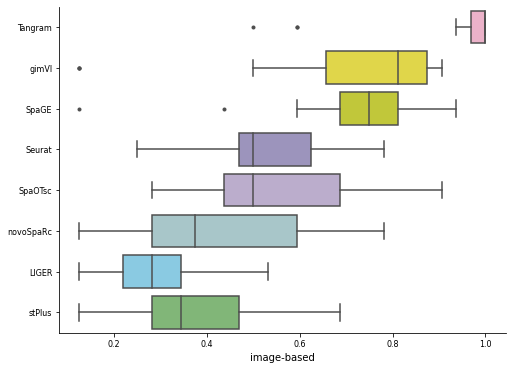

In [15]:
# def make_all_score(path, dataset_all):
#     score_all = pd.DataFrame()
#     for dataset in dataset_all:
#         a = pd.read_csv(path + '/Accuracy_Rank/'+dataset+"_score.txt",header=0,index_col=0)
#         a['DataSet'] = dataset
#         score_all=pd.concat([score_all,a],axis=0)
#     return score_all


# def plot_all(df, name, order, palette, path):
#     df = df[['PCC', 'SSIM', 'RMSE', 'JS']]
#     df_all = pd.DataFrame(df.sum(axis=1).values,index = df.index.values,columns=['merge'])
#     df_all = df_all/4
    
#     plt.figure(figsize=(8, 6))
#     axes =sns.boxplot(x= 'merge',y= df_all.index.values, data=df_all ,palette=palette,order=order,flierprops = dict(marker='o', markersize=3))
#     axes.set_xlabel(name, fontsize=10)
#     axes.set_ylabel('', fontsize=10)
#     axes.spines['top'].set_visible(False)
#     axes.spines['right'].set_visible(False)
#     plt.xticks(fontsize=8)
#     plt.yticks(fontsize=8)
#     plt.savefig(path + "/Accuracy_Rank/" + name + '_boxplot.pdf')
#     plt.show()

# path = 'FigureData/Figure2/Metrics/'
# os.popen('mkdir ' + path + 'Accuracy_Rank')
# path_output = path + '/Accuracy_Rank/'
# order = ['Tangram', 'gimVI', 'SpaGE', 'Seurat', 'SpaOTsc', 'novoSpaRc', 'LIGER', 'stPlus']
# Tools= ['Tangram', 'gimVI', 'SpaGE', 'Seurat', 'SpaOTsc', 'novoSpaRc', 'LIGER', 'stPlus']
# palette = ["#F5A8C7", '#F9EC31', "#D6DE23", "#988DC3", "#BBA8D1", "#A2CBCF", "#7BD1F1", "#79c06e"]

# DirFiles = os.listdir(path)
# DataSets = [x for x in DirFiles if x[:4] == 'Data']
# image_based_dataset = ['Data1', 'Data2', 'Data3', 'Data4', 'Data5', 'Data6', 'Data7', 'Data8', 'Data9', 
#             'Data10', 'Data11', 'Data12', 'Data13', 'Data14', 'Data15', 'Data16', 'Data17']
# seq_based_dataset = [x for x in DataSets if x not in image_based_dataset]
# print (len(DataSets))
# print (len(seq_based_dataset))
# print (len(image_based_dataset))


# image_based = make_all_score(path, image_based_dataset)
# image_based.to_csv(path + "/Accuracy_Rank/image_based_score.txt",header=1, index=1)

# seq_based = make_all_score(path, seq_based_dataset)
# seq_based.to_csv(path + "/Accuracy_Rank/seq_based_score.txt",header=1, index=1)

# plot_image = pd.read_csv(path + "/Accuracy_Rank/image_based_score.txt", header = 0, index_col = 0)
# plot_image.loc[plot_image['DataSet'] == 'Data8', 'JS'] = 0
# plot_seq = pd.read_csv(path + "/Accuracy_Rank/seq_based_score.txt", header = 0, index_col = 0)

# plot_all(plot_seq, 'seq-based', order, palette, path)
# plot_all(plot_image, 'image-based', order, palette, path)


# Accuracy for all datasets

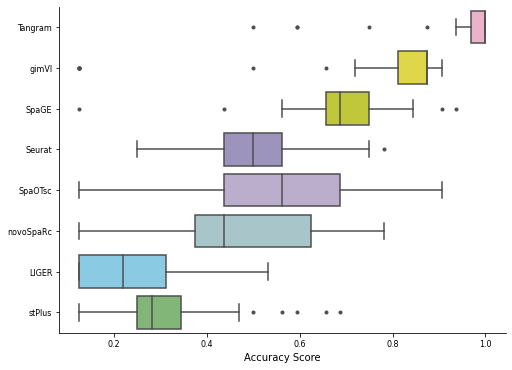

In [16]:
# path = 'FigureData/Figure2/Metrics/'
# all_based = make_all_score(path, DataSets)
# all_based.to_csv(path + "/Accuracy_Rank/Score.txt", header = 1, index = 1)
# plot_data = pd.read_csv(path + "/Accuracy_Rank/Score.txt", header = 0, index_col = 0)
# # JS of Dataset8 is Inf for all methods, because the spatial data has been scaled.
# plot_data.loc[plot_data['DataSet'] == 'Data8', 'JS'] = 0
# plot_all(plot_data, 'Accuracy Score', order, palette, path)

# Accuracy for MERFISH datasets

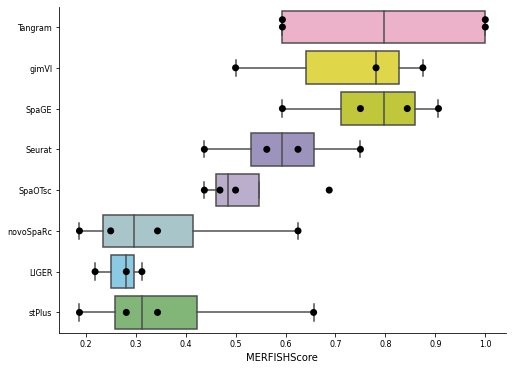

In [18]:
# def plot_all(df, name, order, palette, path):
#     df = df[['PCC', 'SSIM', 'RMSE', 'JS']]
#     df_all = pd.DataFrame(df.sum(axis=1).values,index = df.index.values,columns=['merge'])
#     df_all = df_all/4
    
#     plt.figure(figsize=(8, 6))
#     axes = sns.boxplot(x= 'merge',y= df_all.index.values, data = df_all ,palette=palette,order=order,flierprops = dict(marker='o', markersize=3))
#     axes = sns.swarmplot(x = 'merge', y = df_all.index.values, data = df_all, order = order, color = "black", size = 7)
#     axes.set_xlabel(name, fontsize=10)
#     axes.set_ylabel('', fontsize=10)
#     axes.spines['top'].set_visible(False)
#     axes.spines['right'].set_visible(False)
#     plt.xticks(fontsize=8)
#     plt.yticks(fontsize=8)
#     plt.savefig(path + "/Accuracy_Rank/" + name + '_boxplot.pdf')
#     plt.show()
    
# order = ['Tangram', 'gimVI', 'SpaGE', 'Seurat', 'SpaOTsc', 'novoSpaRc', 'LIGER', 'stPlus']
# palette = ["#F5A8C7", '#F9EC31', "#D6DE23", "#988DC3", "#BBA8D1", "#A2CBCF", "#7BD1F1", "#79c06e"]    
# path = 'FigureData/Figure2/Metrics/'
# MERFISHBased = ['Data6', 'Data7', 'Data8', 'Data9']
# MERFISH_based = make_all_score(path,MERFISHBased)
# MERFISH_based.to_csv(path + "/Accuracy_Rank/MERFISH_score.txt", header = 1, index = 1)
# plot_MERFISH = pd.read_csv(path + "/Accuracy_Rank/MERFISH_score.txt", header = 0, index_col = 0)
# plot_MERFISH['Tool'] = plot_MERFISH.index
# plot_MERFISH.index = plot_MERFISH['Tool'] + '_' + plot_MERFISH['DataSet']

# ### Removed LIGER and gimVI's scores for Data8 because an error occurred when making predictions for Dataset 8 using these two tools.

# plot_MERFISH = plot_MERFISH.drop('LIGER_Data8', axis = 0)
# plot_MERFISH = plot_MERFISH.drop('gimVI_Data8', axis = 0)

# plot_MERFISH.index = plot_MERFISH['Tool']
# plot_MERFISH = plot_MERFISH[['PCC', 'SSIM', 'RMSE', 'JS', 'DataSet']]
# plot_MERFISH.loc[plot_MERFISH['DataSet'] == 'Data8', 'JS'] = 0
# plot_all(plot_MERFISH, 'MERFISHScore', order, palette, path)

